In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [75]:
#! /usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import gc

import numpy as np
import torch
from torch import nn
import torch.backends.cudnn as cudnn
from torchvision import transforms

from dataloader import cifar10
from models import VGG11
from src import freeze_influence, hessians, selection
from src.grad_cam import GradCam
import cv2
import matplotlib.pyplot as plt

def load_net(net, path):
    assert os.path.isfile(path), "Error: no checkpoint file found!"
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint["net"])
    return net


def save_net(net, path):
    dir, filename = os.path.split(path)
    if not os.path.isdir(dir):
        os.makedirs(dir)

    state = {
        "net": net.state_dict(),
    }
    torch.save(state, path)
    
def plot_raw_image(image, label):
    inv_normalize = transforms.Normalize(
        mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
        std=[1/0.2023, 1/0.1994, 1/0.2010]
    )

    raw_image = transforms.ToPILImage()(inv_normalize(image))
    plt.figure(figsize=(4.36,2.18))
    plt.imshow(raw_image)
    print(f"Label: {label.item()}, {label_tag_list[label.item()]}")

def plot_grad_cam(net, image):
    inv_normalize = transforms.Normalize(
        mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
        std=[1/0.2023, 1/0.1994, 1/0.2010]
    )
    raw_image = inv_normalize(image).permute(1, 2, 0)
    
    grad_cam = GradCam(model=net, module_name="features", layer_name_list=["17", "20", "24", "27"])
    mask_list = grad_cam(image.unsqueeze(0).to(device))

    fig, axs = plt.subplots(1, 4, figsize=(8, 3))

    for i, mask in enumerate(mask_list):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        a, b = np.where(mask < np.mean(mask))
        heatmap[a,b] = [0,0,0]
        heatmap = np.float32(heatmap) / 255 
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)

        cam = heatmap + np.float32(raw_image)
        cam = cam / np.max(cam)
        axs[i].imshow(cam)

    
device = "cuda" if torch.cuda.is_available() else "cpu"
target_removal_label = 0

In [161]:
if device == "cuda":
    cudnn.benchmark = True
label_tag_list = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

net_name = "VGG11"
net_path = f"checkpoints/tab2/{net_name}/cross_entropy/ckpt_0.0.pth"
net = VGG11().to(device)
net = load_net(net, net_path)

if_name = "GIF"
param_ratio = 0.1
net_path = (
    f"checkpoints/tab2/{net_name}/{if_name}/{target_removal_label}_{param_ratio}_{0}.pth"
)
net_GIF_10 = VGG11().to(device)
net_GIF_10 = load_net(net_GIF_10, net_path)

param_ratio = 0.3
net_path = (
    f"checkpoints/tab2/{net_name}/{if_name}/{target_removal_label}_{param_ratio}_{0}.pth"
)
net_GIF_30 = VGG11().to(device)
net_GIF_30 = load_net(net_GIF_30, net_path)

param_ratio = 0.5
net_path = (
    f"checkpoints/tab2/{net_name}/{if_name}/{target_removal_label}_{param_ratio}_{0}.pth"
)
net_GIF_50 = VGG11().to(device)
net_GIF_50 = load_net(net_GIF_50, net_path)

net_path = f"checkpoints/tab2/{net_name}_retrained/cross_entropy/ckpt_0.0_{target_removal_label}.pth"
net_retrained = VGG11().to(device)
net_retrained = load_net(net_retrained, net_path)


net.eval()
num_param = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(
    f"==> Building {net_name} finished. "
    + f"\n    Number of parameters: {num_param}"
)

criterion = nn.CrossEntropyLoss()

# Data
print("==> Preparing data..")
batch_size = 512
num_workers = 1
num_sample_batch = 1

data_loader = cifar10.CIFAR10DataLoader(batch_size, num_workers, validation=False)
train_loader, test_loader = data_loader.get_data_loaders()
print(net)

==> Building VGG11 finished. 
    Number of parameters: 9231114
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1

In [162]:
image_list, label_list = next(iter(test_loader))
removal_index_list = torch.where(label_list == target_removal_label)[0]
remain_index_list = torch.where(label_list != target_removal_label)[0]

Label: 0, airplane


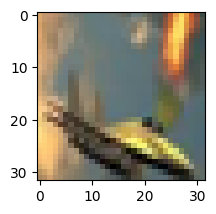

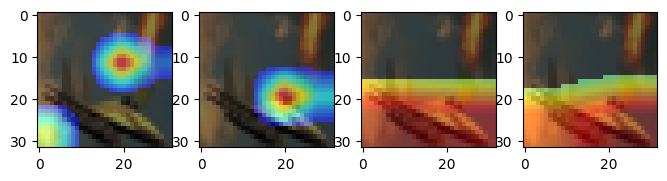

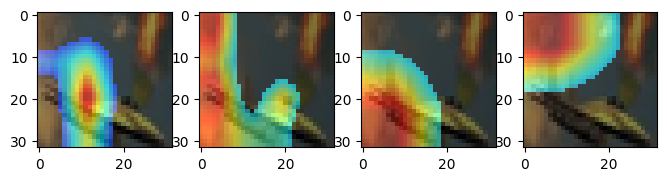

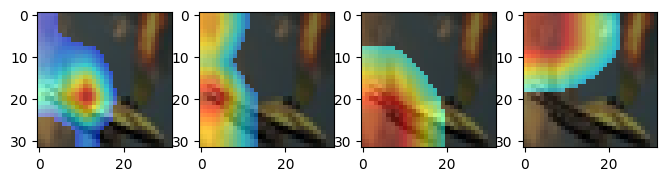

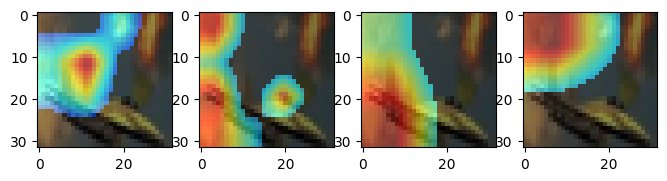

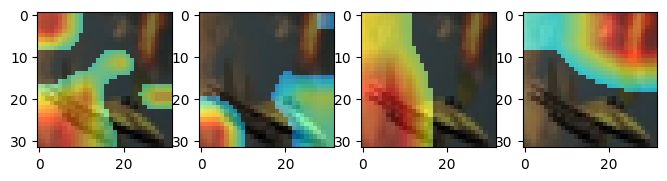

In [179]:
def make_me_comfortable(index):
    image, label = image_list[index], label_list[index]
    plot_raw_image(image, label)
    plot_grad_cam(net, image)
    plot_grad_cam(net_GIF_10, image)
    plot_grad_cam(net_GIF_30, image)
    plot_grad_cam(net_GIF_50, image)
    plot_grad_cam(net_retrained, image)

# 2 9 12! 16! 19!
make_me_comfortable(removal_index_list[12])

Label: 9, truck


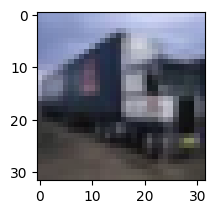

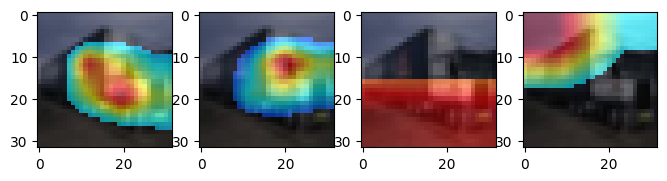

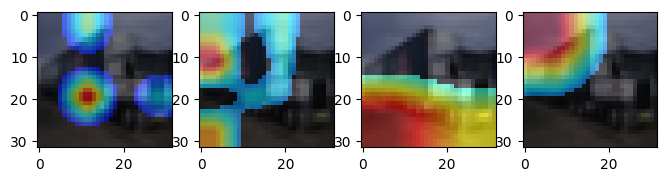

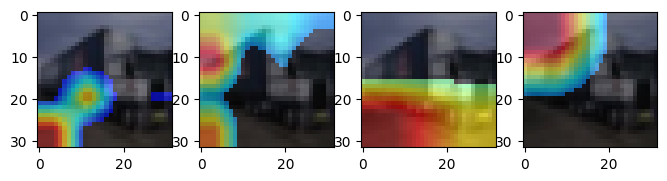

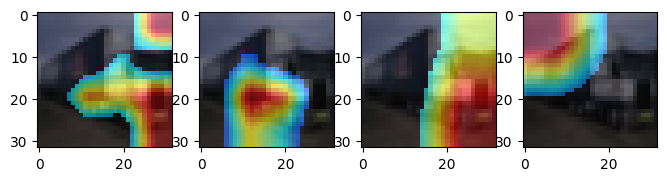

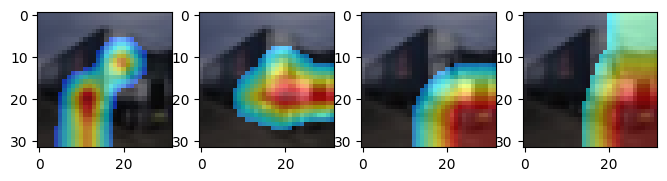

In [177]:
# 11 17! 18! 30 34 39!
make_me_comfortable(remain_index_list[30])